In [1]:
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from statistical_tests import bootstrap_pearsonr, permutation_pearsonr#, bootstrap_pearsonr_mwu

def bootstrap_pearsonr_mwu(y_pred_1, y_pred_2, n_samples=10000, seed=42):
    assert len(y_true) == len(y_pred)
    indices = np.arange(len(y_true))
    coefficients_1 = []
    coefficients_2= []

    r = stats.pearsonr(y_true, y_pred)[0]
    rng = np.random.default_rng(seed)
    for i in range(n_samples):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        y_true_sample = y_true[sample_indices]
        y_pred_sample = y_pred_1[sample_indices]
        r_boot = stats.pearsonr(y_true_sample, y_pred_sample)[0]
        coefficients_1.append(r_boot)
    for i in range(n_samples):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        y_true_sample = y_true[sample_indices]
        y_pred_sample = y_pred_2[sample_indices]
        r_boot = stats.pearsonr(y_true_sample, y_pred_sample)[0]
        coefficients_2.append(r_boot)
    u, p = stats.mannwhitneyu(coefficients_1, coefficients_2, alternative='two-sided')
    return u, p

%matplotlib inline

plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [2]:
pdbbind_training_set_pk = pd.read_csv('../data/pdbbind_training_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
pdbbind_test_set_pk = pd.read_csv('../data/pdbbind_test_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
pdbbind_training_set = pdbbind_training_set_pk.index
pdbbind_test_set = pdbbind_test_set_pk.index

crystal_pose_features = pd.read_csv('../data/crystal_pose_features.csv', index_col=0)
minimised_pose_features = pd.read_csv('../data/minimised_pose_features.csv', index_col=0)
docked_pose_features = pd.read_csv('../data/docked_pose_features.csv', index_col=0)

feature_sets = {}
with open('../data/lb_feature_names.txt') as f:
    feature_sets['LB'] = pd.Index([l.strip() for l in f])
with open('../data/sb_feature_names.txt') as f:
    feature_sets['SB'] = pd.Index([l.strip() for l in f])
with open('../data/hb_feature_names.txt') as f:
    feature_sets['HB'] = pd.Index([l.strip() for l in f])

# List the pose labels corresponding to the docked poses in the training and test sets
with open('../data/docked_pose_labels.json') as f:
    docked_pose_labels = json.load(f)

pdbbind_training_set_labels = []
for pdb in pdbbind_training_set:
    pdbbind_training_set_labels.extend(docked_pose_labels[pdb])
pdbbind_training_set_labels = pd.Index(pdbbind_training_set_labels)

pdbbind_test_set_labels = []
for pdb in pdbbind_test_set:
    pdbbind_test_set_labels.extend(docked_pose_labels[pdb])
pdbbind_test_set_labels = pd.Index(pdbbind_test_set_labels)

The PDB provides clusterings using BLASTclust - we used these to identify structures in the training set that are similar to those in the test set.

In [3]:
blast_clusters = {}
for cutoff in [30, 40, 50, 70, 90, 95, 100]:
    with open(f'../data/bc-{cutoff}.out') as f:
        blast_clusters[cutoff] = [set(item[:4].lower() for item in line.strip().split()) for line in f]

test_set_similar_pdbs = {}
for cutoff in blast_clusters:
    pdbs = set()
    for pdb in pdbbind_test_set:
        for cluster in blast_clusters[cutoff]:
            if pdb in cluster:
                pdbs.update(cluster)
    test_set_similar_pdbs[cutoff] = pd.Index(pdbs).intersection(pdbbind_training_set)

test_set_similar_pdbs['All'] = pd.Index([])

We computed the tanimoto similarity between 2048-bit ECFP4 fingerprints of the ligands in the training and test sets and use these to identify ligands in the training set that are similar to those in the test set.

In [4]:
with open('../data/pdbbind_ligand_tanimoto_similarity.json') as f:
    tanimoto_similarity = json.load(f)

tc_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

test_set_similar_ligands = {}

for t in tc_thresholds:
    similar = set()
    for pdb_test in pdbbind_test_set:
        for pdb_train in pdbbind_training_set:
            if pdb_train in similar:
                continue
            if tanimoto_similarity[pdb_test][pdb_train] >= t:
                similar.add(pdb_train)
    test_set_similar_ligands[t] = pd.Index(similar)
test_set_similar_ligands['All'] = pd.Index([])

### Vina scoring function

For comparison, we score the PDBbind test set using the Autodock Vina scoring function. We use Vina's performance on minimized poses rather than crystal poses as it is susceptible to (what its' scoring function perceives as) steric clash in a small number of crystal structures

In [5]:
y_true = pdbbind_test_set_pk.loc[pdbbind_test_set]

vina_crystal_scores = pd.read_csv('../results/vina_crystal_predicted_pk.csv', index_col=0, squeeze=True)
y_pred = vina_crystal_scores.loc[pdbbind_test_set]
pearsonr_vina_crystal = stats.pearsonr(y_true, y_pred)[0]
pearsonr_vina_crystal_ci = bootstrap_pearsonr(y_true, y_pred)[1:]
pearsonr_vina_crystal_pval = permutation_pearsonr(y_true, y_pred)[1]

vina_docked_scores = pd.read_csv('../results/vina_docked_predicted_pk.csv', index_col=0, squeeze=True)
y_pred = vina_docked_scores.loc[pdbbind_test_set]
pearsonr_vina_docked = stats.pearsonr(y_true, y_pred)[0]
pearsonr_vina_docked_ci = bootstrap_pearsonr(y_true, y_pred)[1:]
pearsonr_vina_docked_pval = permutation_pearsonr(y_true, y_pred)[1]

vina_minimized_scores = pd.read_csv('../results/vina_minimized_predicted_pk.csv', index_col=0, squeeze=True)
y_pred = vina_minimized_scores.loc[pdbbind_test_set]
pearsonr_vina_minimized = stats.pearsonr(y_true, y_pred)[0]
pearsonr_vina_minimized_ci = bootstrap_pearsonr(y_true, y_pred)[1:]
pearsonr_vina_minimized_pval = permutation_pearsonr(y_true, y_pred)[1]

### PDBbind validation - crystal poses

First we obtain a benchmark by training and testing using the crystallographic pose of each ligand. See (Boyles et al., 2020) for details.

In [9]:
results_crystal = {}
pearsonr_crystal = {}
pearsonr_crystal_ci = {}
pearsonr_crystal_pval = {}

for f in feature_sets:
    results_crystal[f] = {}
    pearsonr_crystal[f] = {}
    pearsonr_crystal_ci[f] = {}
    pearsonr_crystal_pval[f] = {}
    for c in test_set_similar_pdbs:
        training_set = pdbbind_training_set.difference(test_set_similar_pdbs[c])
        X_train = crystal_pose_features.loc[training_set, feature_sets[f]]
        X_test = crystal_pose_features.loc[pdbbind_test_set, feature_sets[f]]
        y_train = pdbbind_training_set_pk.loc[training_set].values.ravel()
        y_test = pdbbind_test_set_pk.loc[pdbbind_test_set].values.ravel()

        rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=32)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)
        pearsonr_crystal_ci[f][c] = bootstrap_pearsonr(y_test, y_pred)[1:]
        pearsonr_crystal_pval[f][c] = permutation_pearsonr(y_test, y_pred)[1]
        result = {key: value for key, value in zip(pdbbind_test_set, y_pred)}
        results_crystal[f][c] = result
        pearsonr_crystal[f][c] = stats.pearsonr(y_test, y_pred)[0]
    
    pearsonr_crystal[f] = pd.Series(pearsonr_crystal[f])

with open('../results/pdbbind_test_set_crystal_protein_similarity_results.json', 'w') as f:
    json.dump(results_crystal, f)
    
with open('../results/pdbbind_test_set_crystal_protein_similarity_confidence_intervals.json', 'w') as f:
    json.dump(pearsonr_crystal_ci, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_crystal_protein_similarity_pvalues.json', 'w') as f:
    json.dump(pearsonr_crystal_pval, f, cls=NumpyEncoder)

In [10]:
results_crystal_ts = {}
pearsonr_crystal_ts = {}
pearsonr_crystal_ts_ci = {}
pearsonr_crystal_ts_pval = {}

for f in feature_sets:
    results_crystal_ts[f] = {}
    pearsonr_crystal_ts[f] = {}
    pearsonr_crystal_ts_ci[f] = {}
    pearsonr_crystal_ts_pval[f] = {}
    for c in test_set_similar_ligands:
        training_set = pdbbind_training_set.difference(test_set_similar_ligands[c])
        X_train = crystal_pose_features.loc[training_set, feature_sets[f]]
        X_test = crystal_pose_features.loc[pdbbind_test_set, feature_sets[f]]
        y_train = pdbbind_training_set_pk.loc[training_set].values.ravel()
        y_test = pdbbind_test_set_pk.loc[pdbbind_test_set].values.ravel()

        rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=32)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)
        pearsonr_crystal_ts_ci[f][c] = bootstrap_pearsonr(y_test, y_pred)[1:]
        pearsonr_crystal_ts_pval[f][c] = permutation_pearsonr(y_test, y_pred)[1]
        result = {key: value for key, value in zip(pdbbind_test_set, y_pred)}
        results_crystal_ts[f][c] = result
        pearsonr_crystal_ts[f][c] = stats.pearsonr(y_test, y_pred)[0]
    
    pearsonr_crystal_ts[f] = pd.Series(pearsonr_crystal_ts[f])

with open('../results/pdbbind_test_set_crystal_ligand_similarity_results.json', 'w') as f:
    json.dump(results_crystal_ts, f)
    
with open('../results/pdbbind_test_set_crystal_ligand_similarity_confidence_intervals.json', 'w') as f:
    json.dump(pearsonr_crystal_ts_ci, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_crystal_ligand_similarity_pvalues.json', 'w') as f:
    json.dump(pearsonr_crystal_ts_pval, f, cls=NumpyEncoder)

### PDBbind validation - docked poses

Train on the pdbbind training set using the pose ranked highest by Smina, excluding from the training set any complex with a protein similar to that of any complex in the test set.

In [11]:
predicted = {}
for f in feature_sets:

    predicted[f] = {}
        
    for c in test_set_similar_pdbs:
        training_set = pdbbind_training_set.difference(test_set_similar_pdbs[c])

        # use the top pose for each training complex
        training_set_labels = training_set.map(lambda x: x+'_0')
        X_train = docked_pose_features.loc[training_set_labels, feature_sets[f]]
        y_train = pdbbind_training_set_pk.loc[training_set].values.ravel()

        # use all poses for each test set complex
        X_test = docked_pose_features.loc[pdbbind_test_set_labels, feature_sets[f]]

        rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=8)
        rf.fit(X_train, y_train)
        predicted[f][c] = {key: value for key, value in zip(pdbbind_test_set_labels, rf.predict(X_test))}

with open('../results/pdbbind_test_set_results_protein_similarity.json', 'w') as f:
    json.dump(predicted, f)

Next, repeat the experiment, excluding complexes from the training set if they have a high ligand tanimoto simialrity to anything in the test set.

In [12]:
predicted_ts = {}

for f in feature_sets:
    predicted_ts[f] = {}
    for c in test_set_similar_ligands:

        training_set = pdbbind_training_set.difference(test_set_similar_ligands[c])

        # use the top pose for each training complex
        training_set_labels = training_set.map(lambda x: x+'_0')
        X_train = docked_pose_features.loc[training_set_labels, feature_sets[f]]
        y_train = pdbbind_training_set_pk.loc[training_set].values.ravel()

        # use all poses for each test set complex
        X_test = docked_pose_features.loc[pdbbind_test_set_labels, feature_sets[f]]

        rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=32)
        rf.fit(X_train, y_train)
        result = {key: value for key, value in zip(pdbbind_test_set_labels, rf.predict(X_test))}
        predicted_ts[f][c] = result

with open('../results/pdbbind_test_set_results_ligand_similarity.json', 'w') as f:
    json.dump(predicted_ts, f)

Using the highest score for each ligand, compute the Pearson correlation coefficient between the true and predicted affinity.

In [13]:
max_score = {}

for f in feature_sets:
    max_score[f] = {}
    for c in test_set_similar_pdbs:
        max_score[f][c] = {}
        for pdb in pdbbind_test_set:
            scores = [predicted[f][c][label] for label in docked_pose_labels[pdb]]
            max_score[f][c][pdb] = np.max(scores)
        max_score[f][c] = pd.Series(max_score[f][c])
        
max_score_pearsonr = {}
for f in feature_sets:
    max_score_pearsonr[f] = {}
    for c in test_set_similar_pdbs:
        y_true = pdbbind_test_set_pk.values.ravel()
        y_pred = max_score[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_pearsonr[f][c] = stats.pearsonr(y_true, y_pred)[0]
    max_score_pearsonr[f] = pd.Series(max_score_pearsonr[f])

In [14]:
max_score_ts = {}

for f in feature_sets:
    max_score_ts[f] = {}
    for c in test_set_similar_ligands:
        max_score_ts[f][c] = {}
        for pdb in pdbbind_test_set:
            scores = [predicted_ts[f][c][label] for label in docked_pose_labels[pdb]]
            max_score_ts[f][c][pdb] = np.max(scores)
        max_score_ts[f][c] = pd.Series(max_score_ts[f][c])
        
max_score_pearsonr_ts = {}
for f in feature_sets:
    max_score_pearsonr_ts[f] = {}
    for c in test_set_similar_ligands:
        y_true = pdbbind_test_set_pk.values.ravel()
        y_pred = max_score_ts[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_pearsonr_ts[f][c] = stats.pearsonr(y_true, y_pred)[0]
    max_score_pearsonr_ts[f] = pd.Series(max_score_pearsonr_ts[f])

### Plot performance

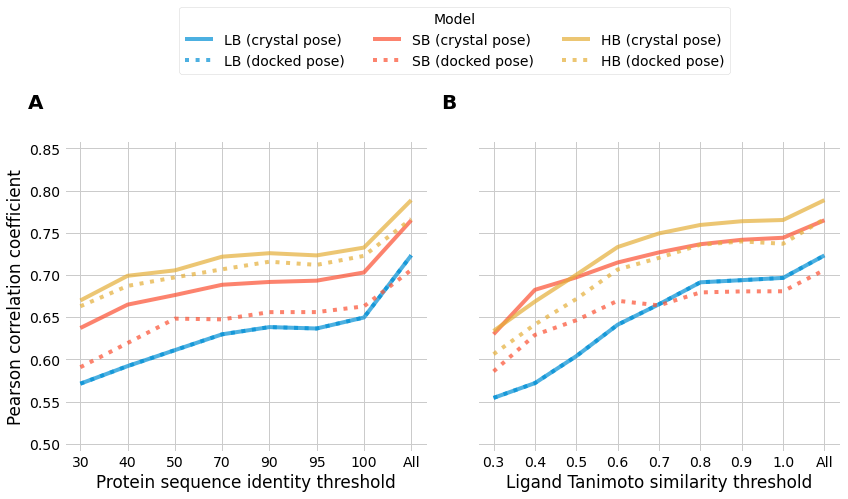

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6),sharey=True)

colours = ['#008fd5', '#fc4f30', '#e5ae38']

for f, c in zip(pearsonr_crystal, colours):
    pearsonr_crystal[f].plot(ax=ax1, label=f+' (crystal pose)', alpha=0.7, color=c)
    max_score_pearsonr[f].plot(ax=ax1, label=f+' (docked pose)', alpha=0.7, linestyle=':', color=c)

ax1.set_ylim(0.49, 0.86)
ax1.set_xlabel('Protein sequence identity threshold')
ax1.set_ylabel('Pearson correlation coefficient')

for f, c in zip(pearsonr_crystal_ts, colours):
    pearsonr_crystal_ts[f].plot(ax=ax2, label=f+' (crystal pose)', alpha=0.7, color=c, xticks=np.arange(0, len(pearsonr_crystal_ts[f]), 1))
    max_score_pearsonr_ts[f].plot(ax=ax2, label=f+' (docked pose)', alpha=0.7,linestyle=':', color=c, xticks=np.arange(0, len(pearsonr_crystal_ts[f]), 1))
ax2.set_xlabel('Ligand Tanimoto similarity threshold')
ax2.set_ylabel('Pearson correlation coefficient')

for ax, annotation in zip((ax1,ax2), ['A', 'B']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
fig.tight_layout()
ax1.legend(title='Model', bbox_to_anchor=(1.85, 1.45), ncol=3)

fig.savefig('../figures/CASF_pearsonr_crystal_dock.png', dpi=350, bbox_inches='tight')

### Statistical significance

In [9]:
with open('../results/pdbbind_test_set_crystal_protein_similarity_results.json') as f:
    results_crystal = json.load(f)
    
with open('../results/pdbbind_test_set_crystal_ligand_similarity_results.json') as f:
    results_crystal_ts = json.load(f)
    
with open('../results/pdbbind_test_set_results_protein_similarity.json') as f:
    predicted = json.load(f)
    
with open('../results/pdbbind_test_set_results_ligand_similarity.json') as f:
    predicted_ts = json.load(f)

In [15]:
max_score = {}

for f in feature_sets:
    max_score[f] = {}
    for c in test_set_similar_pdbs:
        c = str(c)
        max_score[f][c] = {}
        for pdb in pdbbind_test_set:
            scores = [predicted[f][c][label] for label in docked_pose_labels[pdb]]
            max_score[f][c][pdb] = np.max(scores)
        max_score[f][c] = pd.Series(max_score[f][c])
        
max_score_pearsonr = {}
for f in feature_sets:
    max_score_pearsonr[f] = {}
    for c in test_set_similar_pdbs:
        c = str(c)
        y_true = pdbbind_test_set_pk.values.ravel()
        y_pred = max_score[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_pearsonr[f][c] = stats.pearsonr(y_true, y_pred)[0]
    max_score_pearsonr[f] = pd.Series(max_score_pearsonr[f])
    
max_score_ts = {}

for f in feature_sets:
    max_score_ts[f] = {}
    for c in test_set_similar_ligands:
        c = str(c)
        max_score_ts[f][c] = {}
        for pdb in pdbbind_test_set:
            scores = [predicted_ts[f][c][label] for label in docked_pose_labels[pdb]]
            max_score_ts[f][c][pdb] = np.max(scores)
        max_score_ts[f][c] = pd.Series(max_score_ts[f][c])
        
max_score_pearsonr_ts = {}
for f in feature_sets:
    max_score_pearsonr_ts[f] = {}
    for c in test_set_similar_ligands:
        c = str(c)
        y_true = pdbbind_test_set_pk.values.ravel()
        y_pred = max_score_ts[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_pearsonr_ts[f][c] = stats.pearsonr(y_true, y_pred)[0]
    max_score_pearsonr_ts[f] = pd.Series(max_score_pearsonr_ts[f])

In [18]:
crystal_pearsonr_ci = {}
crystal_pearsonr_pval = {}
crystal_pearsonr_ci_ts = {}
crystal_pearsonr_pval_ts = {}
y_true = pdbbind_test_set_pk.values.ravel()
for f in max_score:
    crystal_pearsonr_ci[f] = {}
    crystal_pearsonr_pval[f] = {}
    for c in max_score[f]:
        y_pred = pd.Series(results_crystal[f][c]).loc[pdbbind_test_set_pk.index].values.ravel()
        crystal_pearsonr_ci[f][c] = bootstrap_pearsonr(y_true, y_pred)
        crystal_pearsonr_pval[f][c] = permutation_pearsonr(y_true, y_pred)
    crystal_pearsonr_ci_ts[f] = {}
    crystal_pearsonr_pval_ts[f] = {}
    for c in max_score_ts[f]:
        y_pred = pd.Series(results_crystal_ts[f][c]).loc[pdbbind_test_set_pk.index].values.ravel()
        crystal_pearsonr_ci_ts[f][c] = bootstrap_pearsonr(y_true, y_pred)
        crystal_pearsonr_pval_ts[f][c] = permutation_pearsonr(y_true, y_pred)

In [19]:
max_score_pearsonr_ci = {}
max_score_pearsonr_pval = {}
max_score_pearsonr_ci_ts = {}
max_score_pearsonr_pval_ts = {}
y_true = pdbbind_test_set_pk.values.ravel()
for f in max_score:
    max_score_pearsonr_ci[f] = {}
    max_score_pearsonr_pval[f] = {}
    for c in max_score[f]:
        y_pred = max_score[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_pearsonr_ci[f][c] = bootstrap_pearsonr(y_true, y_pred)
        max_score_pearsonr_pval[f][c] = permutation_pearsonr(y_true, y_pred)
    max_score_pearsonr_ci_ts[f] = {}
    max_score_pearsonr_pval_ts[f] = {}
    for c in max_score_ts[f]:
        y_pred = max_score_ts[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_pearsonr_ci_ts[f][c] = bootstrap_pearsonr(y_true, y_pred)
        max_score_pearsonr_pval_ts[f][c] = permutation_pearsonr(y_true, y_pred)

In [24]:
for cutoff in crystal_pearsonr_ci['LB']:
    lb = crystal_pearsonr_ci['LB'][cutoff]
    sb = crystal_pearsonr_ci['SB'][cutoff]
    hb = crystal_pearsonr_ci['HB'][cutoff]
    print(f'{cutoff} & {lb[0]:.3f} ({lb[1]:.3f}, {lb[2]:.3f}) & {sb[0]:.3f} ({sb[1]:.3f}, {sb[2]:.3f}) & {hb[0]:.3f} ({hb[1]:.3f}, {hb[2]:.3f}) \\\\')

30 & 0.571 (0.511, 0.627) & 0.637 (0.588, 0.682) & 0.670 (0.622, 0.712) \\
40 & 0.592 (0.534, 0.646) & 0.665 (0.618, 0.708) & 0.699 (0.653, 0.739) \\
50 & 0.611 (0.553, 0.663) & 0.676 (0.630, 0.718) & 0.706 (0.661, 0.745) \\
70 & 0.630 (0.575, 0.679) & 0.689 (0.643, 0.729) & 0.722 (0.679, 0.759) \\
90 & 0.638 (0.584, 0.687) & 0.692 (0.647, 0.733) & 0.726 (0.683, 0.763) \\
95 & 0.637 (0.582, 0.687) & 0.693 (0.647, 0.735) & 0.723 (0.680, 0.761) \\
100 & 0.650 (0.596, 0.698) & 0.703 (0.658, 0.744) & 0.733 (0.690, 0.769) \\
All & 0.723 (0.677, 0.766) & 0.765 (0.723, 0.801) & 0.789 (0.752, 0.822) \\


In [26]:
for cutoff in crystal_pearsonr_ci_ts['LB']:
    lb = crystal_pearsonr_ci_ts['LB'][cutoff]
    sb = crystal_pearsonr_ci_ts['SB'][cutoff]
    hb = crystal_pearsonr_ci_ts['HB'][cutoff]
    print(f'{cutoff} & {lb[0]:.3f} ({lb[1]:.3f}, {lb[2]:.3f}) & {sb[0]:.3f} ({sb[1]:.3f}, {sb[2]:.3f}) & {hb[0]:.3f} ({hb[1]:.3f}, {hb[2]:.3f}) \\\\')

0.3 & 0.554 (0.490, 0.614) & 0.630 (0.577, 0.677) & 0.634 (0.580, 0.683) \\
0.4 & 0.572 (0.510, 0.629) & 0.683 (0.638, 0.723) & 0.669 (0.619, 0.714) \\
0.5 & 0.604 (0.545, 0.657) & 0.697 (0.654, 0.736) & 0.700 (0.655, 0.741) \\
0.6 & 0.641 (0.585, 0.691) & 0.715 (0.673, 0.753) & 0.733 (0.691, 0.771) \\
0.7 & 0.665 (0.610, 0.716) & 0.727 (0.684, 0.765) & 0.749 (0.706, 0.787) \\
0.8 & 0.691 (0.640, 0.738) & 0.737 (0.694, 0.774) & 0.759 (0.717, 0.796) \\
0.9 & 0.694 (0.642, 0.741) & 0.742 (0.700, 0.779) & 0.764 (0.721, 0.800) \\
1.0 & 0.697 (0.645, 0.744) & 0.744 (0.703, 0.781) & 0.765 (0.723, 0.801) \\
All & 0.723 (0.677, 0.766) & 0.765 (0.723, 0.801) & 0.789 (0.752, 0.822) \\


In [27]:
for cutoff in max_score_pearsonr_ci['LB']:
    lb = max_score_pearsonr_ci['LB'][cutoff]
    sb = max_score_pearsonr_ci['SB'][cutoff]
    hb = max_score_pearsonr_ci['HB'][cutoff]
    print(f'{cutoff} & {lb[0]:.3f} ({lb[1]:.3f}, {lb[2]:.3f}) & {sb[0]:.3f} ({sb[1]:.3f}, {sb[2]:.3f}) & {hb[0]:.3f} ({hb[1]:.3f}, {hb[2]:.3f}) \\\\')

30 & 0.571 (0.511, 0.627) & 0.591 (0.536, 0.641) & 0.663 (0.616, 0.706) \\
40 & 0.592 (0.534, 0.646) & 0.619 (0.568, 0.667) & 0.687 (0.640, 0.730) \\
50 & 0.611 (0.553, 0.663) & 0.648 (0.600, 0.693) & 0.697 (0.651, 0.738) \\
70 & 0.630 (0.575, 0.679) & 0.647 (0.598, 0.693) & 0.707 (0.661, 0.746) \\
90 & 0.638 (0.584, 0.687) & 0.656 (0.607, 0.701) & 0.716 (0.672, 0.754) \\
95 & 0.637 (0.582, 0.687) & 0.656 (0.607, 0.701) & 0.712 (0.667, 0.751) \\
100 & 0.650 (0.596, 0.698) & 0.663 (0.614, 0.708) & 0.723 (0.680, 0.760) \\
All & 0.723 (0.677, 0.766) & 0.706 (0.660, 0.749) & 0.766 (0.726, 0.802) \\


In [28]:
for cutoff in max_score_pearsonr_ci_ts['LB']:
    lb = max_score_pearsonr_ci_ts['LB'][cutoff]
    sb = max_score_pearsonr_ci_ts['SB'][cutoff]
    hb = max_score_pearsonr_ci_ts['HB'][cutoff]
    print(f'{cutoff} & {lb[0]:.3f} ({lb[1]:.3f}, {lb[2]:.3f}) & {sb[0]:.3f} ({sb[1]:.3f}, {sb[2]:.3f}) & {hb[0]:.3f} ({hb[1]:.3f}, {hb[2]:.3f}) \\\\')

0.3 & 0.554 (0.490, 0.614) & 0.586 (0.529, 0.638) & 0.606 (0.549, 0.658) \\
0.4 & 0.572 (0.510, 0.629) & 0.629 (0.578, 0.676) & 0.641 (0.589, 0.689) \\
0.5 & 0.604 (0.545, 0.657) & 0.646 (0.596, 0.692) & 0.672 (0.623, 0.715) \\
0.6 & 0.641 (0.585, 0.691) & 0.670 (0.621, 0.715) & 0.707 (0.660, 0.748) \\
0.7 & 0.665 (0.610, 0.716) & 0.664 (0.613, 0.711) & 0.720 (0.675, 0.760) \\
0.8 & 0.691 (0.640, 0.738) & 0.679 (0.629, 0.725) & 0.736 (0.690, 0.776) \\
0.9 & 0.694 (0.642, 0.741) & 0.681 (0.631, 0.726) & 0.740 (0.695, 0.779) \\
1.0 & 0.697 (0.645, 0.744) & 0.681 (0.632, 0.725) & 0.737 (0.691, 0.777) \\
All & 0.723 (0.677, 0.766) & 0.706 (0.660, 0.749) & 0.766 (0.726, 0.802) \\


In [33]:
with open('../results/pdbbind_test_set_docked_protein_similarity_confidence_intervals.json', 'w') as f:
    json.dump(max_score_pearsonr_ci, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_docked_protein_similarity_pvalues.json', 'w') as f:
    json.dump(max_score_pearsonr_pval, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_docked_ligand_similarity_confidence_intervals.json', 'w') as f:
    json.dump(max_score_pearsonr_ci_ts, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_docked_ligand_similarity_pvalues.json', 'w') as f:
    json.dump(max_score_pearsonr_pval_ts, f, cls=NumpyEncoder)

In [135]:
max_score_pearsonr_mwu = {}
for f in max_score:
    max_score_pearsonr_mwu[f] = {}
    for c in max_score[f]:
        y_pred_crystal = pd.Series(results_crystal[f][c]).loc[pdbbind_test_set_pk.index].values.ravel()
        y_pred_docked = max_score[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_pearsonr_mwu[f][c] = bootstrap_pearsonr_mwu(y_pred_crystal, y_pred_docked)

In [140]:
sb_hb_pearsonr_mwu = {'Crystal': {}, 'Docked': {}}
for c in results_crystal['SB']:
    y_pred_sb = pd.Series(results_crystal['SB'][c]).loc[pdbbind_test_set_pk.index].values.ravel()
    y_pred_hb = pd.Series(results_crystal['HB'][c]).loc[pdbbind_test_set_pk.index].values.ravel()
    sb_hb_pearsonr_mwu['Crystal'][c] = bootstrap_pearsonr_mwu(y_pred_sb, y_pred_hb)
    y_pred_sb = pd.Series(max_score['SB'][c]).loc[pdbbind_test_set_pk.index].values.ravel()
    y_pred_hb = pd.Series(max_score['HB'][c]).loc[pdbbind_test_set_pk.index].values.ravel()
    sb_hb_pearsonr_mwu['Docked'][c] = bootstrap_pearsonr_mwu(y_pred_sb, y_pred_hb)
    
sb_hb_pearsonr_mwu_ts = {'Crystal': {}, 'Docked': {}}
for c in results_crystal_ts['SB']:
    y_pred_sb = pd.Series(results_crystal_ts['SB'][c]).loc[pdbbind_test_set_pk.index].values.ravel()
    y_pred_hb = pd.Series(results_crystal_ts['HB'][c]).loc[pdbbind_test_set_pk.index].values.ravel()
    sb_hb_pearsonr_mwu_ts['Crystal'][c] = bootstrap_pearsonr_mwu(y_pred_sb, y_pred_hb)
    y_pred_sb = pd.Series(max_score_ts['SB'][c]).loc[pdbbind_test_set_pk.index].values.ravel()
    y_pred_hb = pd.Series(max_score_ts['HB'][c]).loc[pdbbind_test_set_pk.index].values.ravel()
    sb_hb_pearsonr_mwu_ts['Docked'][c] = bootstrap_pearsonr_mwu(y_pred_sb, y_pred_hb)

### PDBbind validation - training using multiple poses

We repeat the above, this time training using every docked pose for each ligand in the training set.

In [23]:
results_train_all_docks = {}

for f in feature_sets:
    results_train_all_docks[f] = {}
    for c in test_set_similar_pdbs:
        training_set = pdbbind_training_set.difference(test_set_similar_pdbs[c])
        training_labels = pd.Index([i for pdb in training_set for i in docked_pose_labels[pdb]])
        X_train = docked_pose_features.loc[training_labels, feature_sets[f]]

        training_set_pdbs = training_labels.map(lambda x: x[:4])
        y_train = pdbbind_training_set_pk.loc[training_set_pdbs].values.ravel()

        X_test = docked_pose_features.loc[pdbbind_test_set_labels, feature_sets[f]]
        rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=6)
        rf.fit(X_train, y_train)
        result = {key: value for key, value in zip(pdbbind_test_set_labels, rf.predict(X_test))}
        results_train_all_docks[f][c] = result

In [24]:
max_score_train_all_docks = {}

for f in feature_sets:
    max_score_train_all_docks[f] = {}
    for c in test_set_similar_pdbs:
        max_score_train_all_docks[f][c] = {}
        for pdb in pdbbind_test_set:
            scores = [results_train_all_docks[f][c][key] for key in docked_pose_labels[pdb]]
            max_score_train_all_docks[f][c][pdb] = np.max(scores)
        max_score_train_all_docks[f][c] = pd.Series(max_score_train_all_docks[f][c])
        
max_score_train_all_docks_pearsonr = {}
for f in feature_sets:
    max_score_train_all_docks_pearsonr[f] = {}
    for c in test_set_similar_pdbs:
        y_true = pdbbind_test_set_pk.values.ravel()
        y_pred = max_score_train_all_docks[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_train_all_docks_pearsonr[f][c] = stats.pearsonr(y_true, y_pred)[0]
    max_score_train_all_docks_pearsonr[f] = pd.Series(max_score_train_all_docks_pearsonr[f])

In [25]:
with open('../results/pdbbind_test_set_all_docks_results_protein_similarity.json', 'w') as f:
    json.dump(results_train_all_docks, f)

In [26]:
results_train_all_docks_ts = {}

for f in feature_sets:
    results_train_all_docks_ts[f] = {}
    for c in test_set_similar_ligands:
        training_set = pdbbind_training_set.difference(test_set_similar_ligands[c])
        training_labels = pd.Index([i for pdb in training_set for i in docked_pose_labels[pdb]])
        X_train = docked_pose_features.loc[training_labels, feature_sets[f]]

        training_set_pdbs = training_labels.map(lambda x: x[:4])
        y_train = pdbbind_training_set_pk.loc[training_set_pdbs].values.ravel()

        X_test = docked_pose_features.loc[pdbbind_test_set_labels, feature_sets[f]]
        rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=6)
        rf.fit(X_train, y_train)
        result = {key: value for key, value in zip(pdbbind_test_set_labels, rf.predict(X_test))}
        results_train_all_docks_ts[f][c] = result

In [27]:
max_score_train_all_docks_ts = {}

for f in feature_sets:
    max_score_train_all_docks_ts[f] = {}
    for c in test_set_similar_ligands:
        max_score_train_all_docks_ts[f][c] = {}
        for pdb in pdbbind_test_set:
            scores = [results_train_all_docks_ts[f][c][key] for key in docked_pose_labels[pdb]]
            max_score_train_all_docks_ts[f][c][pdb] = np.max(scores)
        max_score_train_all_docks_ts[f][c] = pd.Series(max_score_train_all_docks_ts[f][c])
        
max_score_train_all_docks_pearsonr_ts = {}
for f in feature_sets:
    max_score_train_all_docks_pearsonr_ts[f] = {}
    for c in test_set_similar_ligands:
        y_true = pdbbind_test_set_pk.values.ravel()
        y_pred = max_score_train_all_docks_ts[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_train_all_docks_pearsonr_ts[f][c] = stats.pearsonr(y_true, y_pred)[0]
    max_score_train_all_docks_pearsonr_ts[f] = pd.Series(max_score_train_all_docks_pearsonr_ts[f])

In [28]:
with open('../results/pdbbind_test_set_all_docks_results_ligand_similarity.json', 'w') as f:
    json.dump(results_train_all_docks_ts, f)

### Statistical significance

In [29]:
all_docks_pearsonr_ci = {}
all_docks_pearsonr_pval = {}
all_docks_pearsonr_ci_ts = {}
all_docks_pearsonr_pval_ts = {}
y_true = pdbbind_test_set_pk.values.ravel()
for f in max_score_train_all_docks:
    all_docks_pearsonr_ci[f] = {}
    all_docks_pearsonr_pval[f] = {}
    for c in max_score_train_all_docks[f]:
        y_pred = max_score_train_all_docks[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        all_docks_pearsonr_ci[f][c] = bootstrap_pearsonr(y_true, y_pred)[1:]
        all_docks_pearsonr_pval[f][c] = permutation_pearsonr(y_true, y_pred)[1]
    all_docks_pearsonr_ci_ts[f] = {}
    all_docks_pearsonr_pval_ts[f] = {}
    for c in max_score_train_all_docks_ts[f]:
        y_pred = max_score_train_all_docks_ts[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        all_docks_pearsonr_ci_ts[f][c] = bootstrap_pearsonr(y_true, y_pred)[1:]
        all_docks_pearsonr_pval_ts[f][c] = permutation_pearsonr(y_true, y_pred)[1]

In [31]:
with open('../results/pdbbind_test_set_all_docks_protein_similarity_confidence_intervals.json', 'w') as f:
    json.dump(all_docks_pearsonr_ci, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_all_docks_protein_similarity_pvalues.json', 'w') as f:
    json.dump(all_docks_pearsonr_pval, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_all_docks_ligand_similarity_confidence_intervals.json', 'w') as f:
    json.dump(all_docks_pearsonr_ci_ts, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_all_docks_ligand_similarity_pvalues.json', 'w') as f:
    json.dump(all_docks_pearsonr_pval_ts, f, cls=NumpyEncoder)

### Redundant poses

To control for training set size, we repeat the previous experiment using redundant poses instead of diverse poses.

In [34]:
results_train_redundant_docks = {}

for f in feature_sets:
    results_train_redundant_docks[f] = {}
    for c in test_set_similar_pdbs:
        training_set = pdbbind_training_set.difference(test_set_similar_pdbs[c])
        training_labels = pd.Index([i for pdb in training_set for i in docked_pose_labels[pdb]])
        training_labels = training_labels.map(lambda x: x[:4]+'_0')
        X_train = docked_pose_features.loc[training_labels, feature_sets[f]]

        training_set_pdbs = training_labels.map(lambda x: x[:4])
        y_train = pdbbind_training_set_pk.loc[training_set_pdbs].values.ravel()

        X_test = docked_pose_features.loc[pdbbind_test_set_labels, feature_sets[f]]
        rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=6)
        rf.fit(X_train, y_train)
        result = {key: value for key, value in zip(pdbbind_test_set_labels, rf.predict(X_test))}
        results_train_redundant_docks[f][c] = result

In [35]:
max_score_train_redundant_docks = {}

for f in feature_sets:
    max_score_train_redundant_docks[f] = {}
    for c in test_set_similar_pdbs:
        max_score_train_redundant_docks[f][c] = {}
        for pdb in pdbbind_test_set:
            scores = [results_train_redundant_docks[f][c][key] for key in docked_pose_labels[pdb]]
            max_score_train_redundant_docks[f][c][pdb] = np.max(scores)
        max_score_train_redundant_docks[f][c] = pd.Series(max_score_train_redundant_docks[f][c])
        
max_score_train_redundant_docks_pearsonr = {}
for f in feature_sets:
    max_score_train_redundant_docks_pearsonr[f] = {}
    for c in test_set_similar_pdbs:
        y_true = pdbbind_test_set_pk.values.ravel()
        y_pred = max_score_train_redundant_docks[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_train_redundant_docks_pearsonr[f][c] = stats.pearsonr(y_true, y_pred)[0]
    max_score_train_redundant_docks_pearsonr[f] = pd.Series(max_score_train_redundant_docks_pearsonr[f])

In [36]:
with open('../results/pdbbind_test_set_redundant_docks_results_protein_similarity.json', 'w') as f:
    json.dump(results_train_redundant_docks, f)

In [37]:
results_train_redundant_docks_ts = {}

for f in feature_sets:
    results_train_redundant_docks_ts[f] = {}
    for c in test_set_similar_ligands:
        training_set = pdbbind_training_set.difference(test_set_similar_ligands[c])
        training_labels = pd.Index([i for pdb in training_set for i in docked_pose_labels[pdb]])
        training_labels = training_labels.map(lambda x: x[:4]+'_0')
        X_train = docked_pose_features.loc[training_labels, feature_sets[f]]

        training_set_pdbs = training_labels.map(lambda x: x[:4])
        y_train = pdbbind_training_set_pk.loc[training_set_pdbs].values.ravel()

        X_test = docked_pose_features.loc[pdbbind_test_set_labels, feature_sets[f]]
        rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=6)
        rf.fit(X_train, y_train)
        result = {key: value for key, value in zip(pdbbind_test_set_labels, rf.predict(X_test))}
        results_train_redundant_docks_ts[f][c] = result

In [38]:
max_score_train_redundant_docks_ts = {}

for f in feature_sets:
    max_score_train_redundant_docks_ts[f] = {}
    for c in test_set_similar_ligands:
        max_score_train_redundant_docks_ts[f][c] = {}
        for pdb in pdbbind_test_set:
            scores = [results_train_redundant_docks_ts[f][c][key] for key in docked_pose_labels[pdb]]
            max_score_train_redundant_docks_ts[f][c][pdb] = np.max(scores)
        max_score_train_redundant_docks_ts[f][c] = pd.Series(max_score_train_redundant_docks_ts[f][c])
        
max_score_train_redundant_docks_pearsonr_ts = {}
for f in feature_sets:
    max_score_train_redundant_docks_pearsonr_ts[f] = {}
    for c in test_set_similar_ligands:
        y_true = pdbbind_test_set_pk.values.ravel()
        y_pred = max_score_train_redundant_docks_ts[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        max_score_train_redundant_docks_pearsonr_ts[f][c] = stats.pearsonr(y_true, y_pred)[0]
    max_score_train_redundant_docks_pearsonr_ts[f] = pd.Series(max_score_train_redundant_docks_pearsonr_ts[f])

In [39]:
with open('../results/pdbbind_test_set_redundant_docks_results_ligand_similarity.json', 'w') as f:
    json.dump(results_train_redundant_docks_ts, f)

### Statistical significance

In [40]:
redundant_docks_pearsonr_ci = {}
redundant_docks_pearsonr_pval = {}
redundant_docks_pearsonr_ci_ts = {}
redundant_docks_pearsonr_pval_ts = {}
y_true = pdbbind_test_set_pk.values.ravel()
for f in max_score_train_all_docks:
    redundant_docks_pearsonr_ci[f] = {}
    redundant_docks_pearsonr_pval[f] = {}
    for c in max_score_train_all_docks[f]:
        y_pred = max_score_train_redundant_docks[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        redundant_docks_pearsonr_ci[f][c] = bootstrap_pearsonr(y_true, y_pred)[1:]
        redundant_docks_pearsonr_pval[f][c] = permutation_pearsonr(y_true, y_pred)[1]
    redundant_docks_pearsonr_ci_ts[f] = {}
    redundant_docks_pearsonr_pval_ts[f] = {}
    for c in max_score_train_all_docks_ts[f]:
        y_pred = max_score_train_all_docks_ts[f][c].loc[pdbbind_test_set_pk.index].values.ravel()
        redundant_docks_pearsonr_ci_ts[f][c] = bootstrap_pearsonr(y_true, y_pred)[1:]
        redundant_docks_pearsonr_pval_ts[f][c] = permutation_pearsonr(y_true, y_pred)[1]

In [44]:
with open('../results/pdbbind_test_set_redundant_docks_protein_similarity_confidence_intervals.json', 'w') as f:
    json.dump(redundant_docks_pearsonr_ci, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_redundant_docks_protein_similarity_pvalues.json', 'w') as f:
    json.dump(redundant_docks_pearsonr_pval, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_redundant_docks_ligand_similarity_confidence_intervals.json', 'w') as f:
    json.dump(redundant_docks_pearsonr_ci_ts, f, cls=NumpyEncoder)
    
with open('../results/pdbbind_test_set_redundant_docks_ligand_similarity_pvalues.json', 'w') as f:
    json.dump(redundant_docks_pearsonr_pval_ts, f, cls=NumpyEncoder)

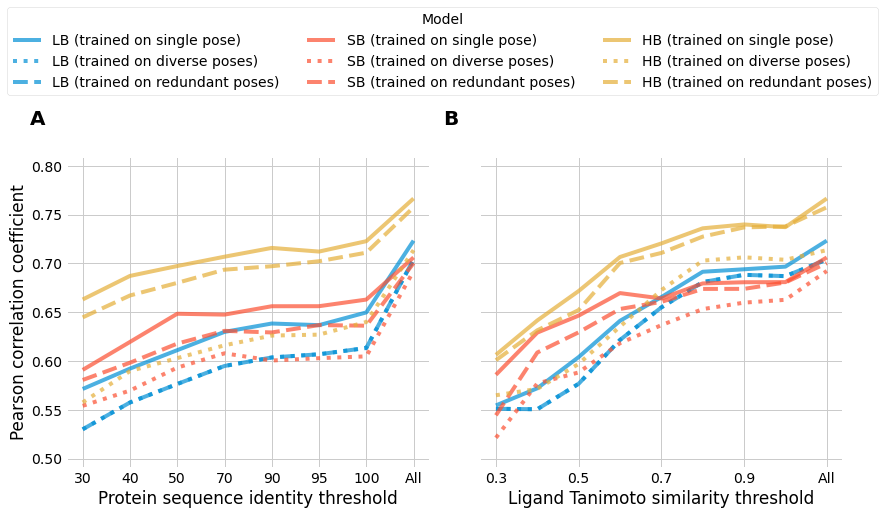

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6),sharey=True)

colours = ['#008fd5', '#fc4f30', '#e5ae38']

for f, c in zip(max_score_pearsonr, colours):
    max_score_pearsonr[f].plot(ax=ax1, label=f+' (trained on single pose)', alpha=0.7, color=c)
    max_score_train_all_docks_pearsonr[f].plot(ax=ax1, label=f+' (trained on diverse poses)', alpha=0.7, linestyle=':', color=c)
    max_score_train_redundant_docks_pearsonr[f].plot(ax=ax1, label=f+' (trained on redundant poses)', alpha=0.7, linestyle='--', color=c)



ax1.set_ylim(0.49, 0.81)
ax1.set_xlabel('Protein sequence identity threshold')
ax1.set_ylabel('Pearson correlation coefficient')

for f, c in zip(max_score_pearsonr_ts, colours):
    max_score_pearsonr_ts[f].plot(ax=ax2, label=f+' (trained on single pose)', alpha=0.7, color=c)
    max_score_train_all_docks_pearsonr_ts[f].plot(ax=ax2, label=f+' (trained on diverse poses)', alpha=0.7, linestyle=':', color=c)
    max_score_train_redundant_docks_pearsonr_ts[f].plot(ax=ax2, label=f+' (trained on redundant poses)', alpha=0.7, linestyle='--', color=c)


ax2.set_xlabel('Ligand Tanimoto similarity threshold')
ax2.set_ylabel('Pearson correlation coefficient')
for ax, annotation in zip((ax1,ax2), ['A', 'B']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
fig.tight_layout()
ax1.legend(title='Model', bbox_to_anchor=(2.25, 1.50), ncol=3)

fig.savefig('../figures/CASF_pearsonr_multiple_docks.png', dpi=350, bbox_inches='tight')

### Leave cluster out

Next, we cluster the PDBbind training set at 90% sequence identity and select large clusters to use in a leave-cluster-out validation. Clusters that overlap are merged.

In [68]:
clusters = [set(cluster).intersection(set(pdbbind_training_set)) for cluster in blast_clusters[90]]
clusters = [cluster for cluster in clusters if cluster]

merged_clusters = [clusters[0]]
already_in = clusters[0].copy()

for cluster in clusters[1:]:
    if cluster.issubset(already_in):
        continue
    new_cluster = True
    for merged_cluster in merged_clusters:
        if cluster.isdisjoint(merged_cluster):
            continue
        merged_cluster.update(cluster)
        new_cluster = False
    if new_cluster:
        merged_clusters.append(cluster)
    already_in.update(cluster)
    
merged_clusters.sort(key=len, reverse=True)

Load the names of the proteins in the PDBbind training set and select the largest clusters.

In [69]:
with open('../data/protein_names.json') as f:
    protein_names = json.load(f)

In [70]:
large_clusters = [c for c in merged_clusters if len(c) > 50]

for cluster in large_clusters:
    cluster_names = set([protein_names[pdb] for pdb in cluster])
    print(cluster_names)

{'HIV-1 PROTEASE E35D-DRV', 'HIV-1 PROTEASE', 'HIV-1 PROTEASE E35D-APV', 'PROTEASE PR5-DRV', 'HIV-1 PROTEASE E35D-SQV', 'PROTEASE PR5-SQV'}
{'CARBONIC ANHYDRASE 2'}
{'TRYPSIN', 'TRYPSIN BETA', 'TRYPSINOGEN'}
{'THROMBIN ALPHA', 'THROMBIN HEAVY CHAIN', 'THROMBIN SHORT CHAIN', 'PROTHROMBIN', 'THROMBIN', 'THROMBIN LIGHT CHAIN'}
{'HEAT SHOCK PROTEIN HSP90-ALPHA'}
{'COAGULATION FACTOR XA', 'COAGULATION FACTOR X'}


In [71]:
test_cluster_names = ['HIV-1 Protease', 'Carbonic Anhydrase 2', 'Trypsin', 'Thrombin', 'HSP90-Alpha', 'Coagualtion factor X/XA']

test_clusters = {name: cluster for name, cluster in zip(test_cluster_names, large_clusters)}

Finally, create a set of proteins that do not fall into any cluster at 90% sequence identity.

In [72]:
test_clusters['Singletons'] = []
for cluster in merged_clusters:
    if len(cluster) ==1 :
        test_clusters['Singletons'].extend(cluster)

Finally, train on the PDBbind training set, holding out each cluster in turn as a validation set.

In [76]:
clustered_pearsonr = {}
clustered_pearsonr_ci = {}
clustered_rmse = {}

for f in feature_sets:
    clustered_pearsonr[f] = {}
    clustered_pearsonr_ci[f] = {}
    clustered_rmse[f] = {}
    for c in test_clusters:

        training_set = pdbbind_training_set.difference(test_clusters[c])

        # use the top pose for each training complex
        training_set_labels = training_set.map(lambda x: x+'_0')
        X_train = docked_pose_features.loc[training_set_labels, feature_sets[f]]
        y_train = pdbbind_training_set_pk.loc[training_set].values.ravel()
        
        rf = RandomForestRegressor(n_estimators=500, max_features=0.33, n_jobs=6, random_state=42)
        rf.fit(X_train, y_train)

        # use all poses for each test set complex
        cluster_pose_labels = []
        for pdb in test_clusters[c]:
            cluster_pose_labels.extend(docked_pose_labels[pdb])
        cluster_pose_labels = pd.Index(cluster_pose_labels)

        X_test = docked_pose_features.loc[cluster_pose_labels, feature_sets[f]]
        y_test = pdbbind_training_set_pk.loc[test_clusters[c]].values.ravel()

        pred = pd.Series(data=rf.predict(X_test), index=cluster_pose_labels)

        max_pred = []
        for pdb in test_clusters[c]:
            max_pred.append(np.max(pred.loc[docked_pose_labels[pdb]]))
        max_pred = np.array(max_pred)
        clustered_pearsonr[f][c] = stats.pearsonr(y_test, max_pred)[0]
        clustered_rmse[f][c] = np.sqrt(mean_squared_error(y_test, max_pred))
        clustered_pearsonr_ci[f][c] = bootstrap_pearsonr(y_test, max_pred)[1:]

clustered_pearsonr = pd.DataFrame(clustered_pearsonr)
clustered_pearsonr.to_csv('../results/pdbbind_training_set_clustered_pearsonr.csv')
clustered_pearsonr

,LB,SB,HB
HIV-1 Protease,0.414335,0.431059,0.450172
Carbonic Anhydrase 2,0.477296,0.522289,0.460208
Trypsin,0.715059,0.727951,0.746460
Thrombin,0.270482,0.367433,0.315544
HSP90-Alpha,0.663356,0.395179,0.591431
Coagualtion factor X/XA,0.111108,-0.097919,-0.100868
Singletons,0.412919,0.484901,0.500084


In [80]:
pd.DataFrame(clustered_pearsonr_ci)[['LB', 'HB']]

,LB,HB
HIV-1 Protease,"(0.29865833212525517, 0.5147223170392993)","(0.34702532659885993, 0.5379314523787657)"
Carbonic Anhydrase 2,"(0.3729045719756661, 0.5717742821528762)","(0.3544559168689021, 0.5549756409892955)"
Trypsin,"(0.5889328866963257, 0.8154416786163291)","(0.6197065867164433, 0.845986045135723)"
Thrombin,"(0.03155411101806844, 0.45827875970574106)","(0.07810648293952048, 0.4932077798596088)"
HSP90-Alpha,"(0.47230151101972584, 0.7925883700926917)","(0.3729961166570789, 0.7412135155373383)"
Coagualtion factor X/XA,"(-0.15351731785345474, 0.33092751191945535)","(-0.3799553478418811, 0.1676550969595748)"
Singletons,"(0.34611387697890833, 0.4767822326209782)","(0.43731462104399643, 0.558573709427791)"


Also score each cluster using the Vina scoring function

In [48]:
vina_scores = pd.read_csv('../results/vina_docked_predicted_pk.csv', index_col=0, squeeze=True)
clustered_vina_pearsonr = {}
clustered_vina_pearsonr_ci = {}
clustered_vina_pearsonr_pval = {}
for c in test_clusters:
    y_pred = vina_scores.loc[test_clusters[c]].values.ravel()
    y_true = pdbbind_training_set_pk.loc[test_clusters[c]].values.ravel()
    clustered_vina_pearsonr[c] = stats.pearsonr(y_true, y_pred)[0]
    clustered_vina_pearsonr_ci[c] = bootstrap_pearsonr(y_true, y_pred)[1:]
    clustered_vina_pearsonr_pval[c] = permutation_pearsonr(y_true, y_pred)[1]